#Introduction
This Notebook was made to show one of the common biological data analysis workflow used in BioInformatics field.

The analysis was carried out on mRNA expression data of lung adenocarcinoma, which was obtained from [GDC Portal](https://portal.gdc.cancer.gov/projects/TCGA-LUAD) as FPKM RNA-seq data.

## lung adenocarcinoma (LUAD)
adenocarcinoma of the lung is the most common type of lung cancer, it is characterized by uncontrolled cell growth in glands that secrete mucus, hence the name adenocarcinoma (adeno: gland).

## Gene Expression Analysis
Cells are the basic building blocks of living things, 50% of our cells are made of proteins, which play important roles in cell structure and function. Cells undergo two processes (Transcription, and Translation) to synthesize proteins, transcription involves copying out gene (part of DNA) to mRNA, and then mRNA is translated into amino acids (protein building blocks) through translation process.

The data that gives an overview of transcription activity is called Transcriptomic, and it represents the quantitative analysis of the collection of all ribonucleic acid (mRNA, rRNA, tRNA, and other non-coding RNAs), while the data that tells us more about the activity of translation process and the amount of produced proteins is called Proteomic.

To get an overview of the dynamic pattern of gene expression at any state of cell (normal / abnormal), the analysis could be performed at one or more levels at which gene expression is regulated [ transcriptional, post-transcriptional, translational, and post-translational ], which in turn gives different types of data (CHIP-seq, Transcriptomic, Proteomic, Phosphoproteomic).

## mRNA Expression Analysis
mRNA analysis is directed to quantify messenger RNA (mRNA) levels of a specific gene. Using different workflows and normalization methods, usually mRNA quantification results are rported  as:

1.   Raw read counts.
2.   RPKM (Reads Per Kilobase Million).
3.   TPM (Transcripts Per Kilobase Million).
4.   FPKM (Fragments per Kilobase of transcript per Million mapped reads).

Throughout the notebook, gene expression term is referred to mRNA expression; as mRNA expression is most commonly used in typical gene expression analysis.



# Data Description
Files and folders that are used in the analysis (as found in GDC Portal):

1.   **Cart**: [folder] contains compressed text files of gene expression (file for each sample).
2.   **Metadata**: [json file] contains different IDs related to samples and files of gene expression, this file will be further used in sample id mapping.
3.   **Clinical**: [folder] contains 3 tsv files (clinical, family_history, exposure).

For downloading data Open [TCGA-LUAD](https://portal.gdc.cancer.gov/projects/TCGA-LUAD) project, and then follow steps (shown in figure below).

<div>
<img src="https://drive.google.com/uc?export=view&id=1TfD5In5xsmPE4L3Qa0vT_KVceR4SRD7c" width="700"/>
</div>

In [ ]:
import numpy as np    # used for working with arrays
import pandas as pd   # used for data analysis
import matplotlib.pyplot as plt    # used for data visualization
import re    # used to work with Regular Expressions
import os    # provides functions for interacting with the operating system
from collections import defaultdict    # provides different types of containers

Read gene expression files into one DataFrame.

In [ ]:
def load_files(files_info):
  """Generate gene-expression df of each sample."""
  for file_path, filename in files_info.items():
    yield pd.read_csv(file_path, compression='gzip', header=None, sep='\t',
                      index_col=0, names=[filename])


# Create dictionary of gene_expression file path & its corresponding file name
gene_exp_file_path_and_name = defaultdict(str)
folder = "/content/drive/MyDrive/Phi/LUAD/expression_files"

for subdir, dirs, files in os.walk(folder):
    for file in files:
        if file.endswith(".FPKM.txt.gz"):
            gene_exp_file_path_and_name[os.path.join(subdir, file)] = file


# Concat the dataframe of each file together into one big dataframe
gene_exp_data = pd.concat(load_files(gene_exp_file_path_and_name), axis=1)

In [ ]:
gene_exp_data.head(3)

,397e302e-393e-4f54-b360-fcffe394271e.FPKM.txt.gz,3f52a1bb-997b-4ee0-b61b-8060e7d8666d.FPKM.txt.gz,bdc9dadb-a543-4965-b85f-8b20b14d4efe.FPKM.txt.gz,037b5a94-487e-4f5b-90a3-d696eb4a8a3e.FPKM.txt.gz,e7bacb69-34d7-476d-a124-5d015bec383d.FPKM.txt.gz,f9d52f9e-4f82-431a-a427-1c1259b8e765.FPKM.txt.gz,8df93787-af1e-4b07-afa1-f910eda02a1c.FPKM.txt.gz,3dd9e081-d183-49b4-8d67-afa513496f21.FPKM.txt.gz,9e49e3ff-f780-48db-9349-e59e2112b6de.FPKM.txt.gz,dc0ce32f-d5aa-489f-ba4b-e01443815121.FPKM.txt.gz,2b2b6341-1f6d-4acc-8a67-0ba8ab051ee8.FPKM.txt.gz,9c75e183-7328-4a63-993e-f28a505017d2.FPKM.txt.gz,2c90459c-9341-4555-bf34-0d6c179751f2.FPKM.txt.gz,1c3039f0-0cd5-4b16-bdbe-128bfbd63b86.FPKM.txt.gz,abc09f7c-a791-4b91-9efa-b6d716811004.FPKM.txt.gz,6ad59e49-f417-4144-9c13-51b24f66422a.FPKM.txt.gz,7dd3791f-7a65-4eea-9be2-3a0ca83ba46d.FPKM.txt.gz,bf8dd7a7-37b1-4a81-9554-d63fdf2fe4f1.FPKM.txt.gz,e77c14e1-1e3f-4f01-992c-b1e68c365005.FPKM.txt.gz,a5e71850-834c-4c39-b4f9-92c952b2cce6.FPKM.txt.gz,d82516e5-6536-4666-b834-82111e0de77b.FPKM.txt.gz,f290cd17-7e92-4c27-be1d-ebf2b7bf8c17.FPKM.txt.gz,18860abf-6fac-490b-8bf2-b906ac1422a4.FPKM.txt.gz,394ef2d0-7bc0-444a-86d3-8f32385c2494.FPKM.txt.gz,20a96363-a968-445a-bd9a-96b27e403516.FPKM.txt.gz,9bab6023-8adb-4257-8c2a-88ddedf4a229.FPKM.txt.gz,4ed9b51a-78a1-48c7-90bd-8ecd2e5767ad.FPKM.txt.gz,5d420937-4d97-4f04-9ce9-754054261d97.FPKM.txt.gz,314b3b08-27e7-4936-a7d9-2dce4e4d3db7.FPKM.txt.gz,87d1452e-8ec6-4c75-a03b-361738c728c0.FPKM.txt.gz,fddb387d-716e-48ca-9e99-483564c5384b.FPKM.txt.gz,83053f28-d761-4d5a-acd6-855cb22e46e2.FPKM.txt.gz,e95d6e6b-6aaf-4003-9dc6-4b464a9d1725.FPKM.txt.gz,ca7c56ab-9248-4c27-8992-8f73746d8d9b.FPKM.txt.gz,b0a26c8d-9863-4352-8abe-dde66bdb8e55.FPKM.txt.gz,1b3deeeb-5fde-4154-a57f-bb575ccfb2be.FPKM.txt.gz,b8181936-6f76-4eec-a57a-92c4cea4f34f.FPKM.txt.gz,38ef59ed-8eb9-4957-a210-4d118df089ce.FPKM.txt.gz,47b14505-ca81-4d39-8eca-0cb773f8934e.FPKM.txt.gz,7f39b57f-556b-46b2-a67a-af86345f900a.FPKM.txt.gz,...,7f73a1b0-8b36-425c-90d6-c1daf18e4a18.FPKM.txt.gz,b1f9bae8-7483-41ba-aab7-7a051850df23.FPKM.txt.gz,d4a55f22-e655-4c8a-bb7f-a1a35eb5e43f.FPKM.txt.gz,df692bf8-d523-4528-aa0c-a0549373adee.FPKM.txt.gz,780ab54f-9100-447b-ba9e-75480e7be3d9.FPKM.txt.gz,f9ea29ab-6953-4646-b367-cff2483b9f46.FPKM.txt.gz,a5869c6f-c024-4eaa-9379-eabe99b45e70.FPKM.txt.gz,a7d6c6ab-c4c7-4d51-8aa6-5adb24f71754.FPKM.txt.gz,485f059b-e143-40b6-b4d2-96bb7497558f.FPKM.txt.gz,dc724482-dc82-41e0-9f01-3451e5be2ae8.FPKM.txt.gz,8dcf8486-6c13-4623-90c9-2c9f65f58fc8.FPKM.txt.gz,39a4a8d9-029d-46bb-8d3e-6edd0d4d1191.FPKM.txt.gz,a55e6cad-f959-47f9-a525-d429099c7e99.FPKM.txt.gz,c07dbc2a-b197-4b5a-a1a7-8acbaea7441e.FPKM.txt.gz,524d2e99-0526-426f-873d-ea65e27b18a0.FPKM.txt.gz,5dbb0cb6-18b4-411e-bfd2-e0f6549dc78f.FPKM.txt.gz,b32ed1d3-c9f1-42c7-ad2a-32794591a839.FPKM.txt.gz,0933e6f7-e2ac-4dc0-b34e-4a45109a28b7.FPKM.txt.gz,e4d01f10-116a-4936-a24b-dda4e6c53397.FPKM.txt.gz,3107533c-054e-463c-b2bc-73ba71ed133a.FPKM.txt.gz,3799992f-2a2b-4a7b-8c21-f493764f4ce8.FPKM.txt.gz,6363e940-3a9d-49f3-adb0-e084be80d95d.FPKM.txt.gz,372ab2b4-31f7-4e79-962e-ce2b4a385c12.FPKM.txt.gz,e879390d-b662-4121-8137-e35bf208edac.FPKM.txt.gz,82bbc554-6c00-4a55-9295-a36ad9e648c3.FPKM.txt.gz,6188f79f-599d-45ff-802f-d1ee94b97b22.FPKM.txt.gz,90af0faf-3e8c-4741-bf49-f87a5b21d54c.FPKM.txt.gz,4ea3866e-01a6-490c-84a5-546c142ebcb5.FPKM.txt.gz,e4de8f87-b9c8-4021-b29a-b7d128ff64a3.FPKM.txt.gz,508976fe-e7a9-4743-a098-2fb0cbe32f8d.FPKM.txt.gz,68acaa5e-6a27-499f-925d-710af9d30710.FPKM.txt.gz,c8fb3217-2cc9-47c0-84b6-b666c07624e6.FPKM.txt.gz,3b1e8e56-f2a3-4a3f-8f99-ba8a8f33152c.FPKM.txt.gz,10d037c2-a3bf-46cf-9e27-0584733f6794.FPKM.txt.gz,e9205c80-39e9-446d-8151-f493e43228c4.FPKM.txt.gz,ce786209-c77d-47e0-95a6-20c036bed8b3.FPKM.txt.gz,186b83bd-ec3f-42b4-ba91-d86c9618d5e3.FPKM.txt.gz,85ac083c-dbb9-4541-8b75-d73ab216f54c.FPKM.txt.gz,cf792f7f-a3ee-4544-b029-8c4e4da4f973.FPKM.txt.gz,022cbd07-3e20-4144-b2ab-8c76adffae73.FPKM.txt.gz
ENSG00000242268.2,0.000000,0.063257,0.362431,0.000000,0.246002,0.000000,0.3

After reading gene expression files into one DataFrame, some changes should be applied on indices and columns names to ease dealing with data in further analysis.


*   Indices: "ENSG00000242268.2" this ensemble gene ends with **.2**, which is used for [versioning ensembles](http://asia.ensembl.org/info/genome/stable_ids/index.html), and so does for other genes. These versioning suffixes will be removed.
*   columns: filename will be replaced with TCGA sample ID (e.g. "397e302e-393e-4f54-b360-fcffe394271e.FPKM.txt.gz" ---> "TCGA-78-7166-01").



TCGA samples are uniquely identified with a [barcode](https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/) that hold their data.

<div>
<img src="https://drive.google.com/uc?export=view&id=1HYa9YQWG4RyFDI4f0HDOBVngY4ypo_nF" width="400"/>
</div>

Above [image](https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/) shows a whole sample ID, however, in our analysis we use only first four parts of the ID (e.g. "TCGA-02-0001-01") as these parts related to a participant's sample ID, while the rest have more detailed info related to how samples are handled in the lab.

In [ ]:
# Read metadata file
meta_path = '/content/drive/MyDrive/Phi/LUAD/metadata.json'
metadata = pd.read_json(meta_path)

# Defining variables to use for extracting curated sample IDs 
row_count = range(metadata.shape[0])
dict_key = metadata.file_name
whole_ids_col = metadata.associated_entities
whole_id_key = 'entity_submitter_id'


def sample_id_extract(row_idx):
  """
  Extract sample ID from whole ID (whole ID e.g. TCGA-MP-A4T8-01A-11R-A24X-07).
  """
  # Curated sample IDs pattern (e.g. TCGA-O1-A52J-01)
  ptn = r'TCGA-([\w|\d]+)-([\w|\d]+)-\d+'
  whole_id = whole_ids_col[row_idx][0][whole_id_key]
  sample_id = re.search(ptn, whole_id)
  return sample_id.group()


# Store filename with its coressponding sample ID in a dictionary
# dict will be used for renaming gene-expression samples with curated sample ID
file_name_with_sample_id = {
    dict_key[row_idx]:sample_id_extract(row_idx) for row_idx in row_count
}

In [ ]:
# Modifying dataframe indices
indices = list(map(lambda idx: idx.split('.')[0], gene_exp_data.index))
gene_exp_data.index = indices

# Renaming the columns with sample IDs
gene_exp_data.rename(columns=file_name_with_sample_id, inplace=True)

In [ ]:
gene_exp_data.head(3)

,TCGA-78-7166-01,TCGA-86-7953-01,TCGA-J2-A4AE-01,TCGA-55-7911-01,TCGA-97-8172-01,TCGA-78-7146-01,TCGA-O1-A52J-01,TCGA-55-8302-01,TCGA-44-8120-01,TCGA-75-6212-01,TCGA-49-4512-11,TCGA-86-8278-01,TCGA-95-7944-01,TCGA-55-8621-01,TCGA-55-6983-01,TCGA-55-6982-01,TCGA-55-A4DF-01,TCGA-49-AAR3-01,TCGA-50-6594-01,TCGA-78-8648-01,TCGA-50-5946-01,TCGA-55-7227-01,TCGA-49-AAQV-01,TCGA-44-6146-01,TCGA-64-1680-01,TCGA-55-6968-01,TCGA-55-7907-01,TCGA-71-6725-01,TCGA-78-7156-01,TCGA-05-4396-01,TCGA-75-7031-01,TCGA-67-6215-01,TCGA-55-6980-11,TCGA-93-A4JQ-01,TCGA-91-6847-01,TCGA-69-7760-01,TCGA-50-5932-01,TCGA-62-A46Y-01,TCGA-38-4628-01,TCGA-44-2661-01,...,TCGA-86-A4JF-01,TCGA-73-4675-01,TCGA-73-4666-01,TCGA-64-5774-01,TCGA-05-4382-01,TCGA-91-7771-01,TCGA-97-8177-01,TCGA-44-A47A-01,TCGA-75-6205-01,TCGA-44-6146-01,TCGA-44-7659-01,TCGA-55-6975-11,TCGA-78-8662-01,TCGA-05-4427-01,TCGA-44-2666-01,TCGA-MP-A4TD-01,TCGA-L9-A7SV-01,TCGA-44-6777-11,TCGA-05-4410-01,TCGA-55-6985-01,TCGA-67-3772-01,TCGA-67-3773-01,TCGA-44-6147-01,TCGA-91-6836-01,TCGA-55-8506-01,TCGA-NJ-A4YQ-01,TCGA-67-3771-01,TCGA-NJ-A55A-01,TCGA-55-7816-01,TCGA-49-6767-01,TCGA-55-6642-01,TCGA-49-4510-01,TCGA-49-4494-01,TCGA-55-8513-01,TCGA-97-A4M3-01,TCGA-64-5778-01,TCGA-97-A4M2-01,TCGA-80-5607-01,TCGA-05-5420-01,TCGA-49-6745-01
ENSG00000242268,0.000000,0.063257,0.362431,0.000000,0.246002,0.000000,0.384900,0.105747,0.039185,0.000000,0.000000,0.049194,0.000000,0.332104,0.020539,0.000000,0.443528,0.000000,0.000000,0.045222,0.021181,0.037240,0.021381,0.465200,0.040832,0.170756,0.049823,0.000000,0.000000,0.148773,0.055471,0.000000,0.000000,0.027306,0.069964,0.033579,0.00000,0.299318,0.000000,0.053879,...,0.027824,0.052288,0.291391,0.000000,0.015471,0.069742,0.000000,0.032842,0.000000,0.054450,0.143752,0.00000,0.000000,0.000000,0.090774,0.000000,0.000000,0.044274,0.000000,0.137065,0.027288,0.000000,0.323466,0.000000,0.000000,0.000000,0.000000,2.730853,0.048440,0.000000,0.000000,0.000000,0.000000,0.613179,0.089709,0.032984,0.089262,0.102384,0.051675,0.032293
ENSG00000270112,0.000000,0.005851,0.000000,0.004529,0.002438,0.000000,0.000000,0.000000,0.002718,0.012390,0.006066,0.002275,0.000000,0.004608,0.000000,0.000000,0.035166,0.000000,0.000000,0.000000,0.005878,0.005167,0.000000,0.000000,0.000000,0.094772,0.000000,0.000000,0.000000,0.006881,0.000000,0.000000,0.000000,0.000000,0.006472,0.013977,0.00000,0.000000,0.000000,0.000000,...,0.065632,0.000000,0.002378,0.004575,0.000000,0.009677,0.000000,0.000000,0.000000,0.000000,0.013297,0.00000,0.000000,0.004997,0.000000,0.000000,0.000000,0.000000,0.000000,0.006339,0.000000,0.000000,0.056102,0.000000,0.000000,0.005628,0.018659,0.077505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004577,0.000000,0.000000,0.000000,0.000000
ENSG00000167578,5.129061,3.247443,4.640633,3.660998,5.406089,0.992468,4.287583,4.360789,2.706488,2.439609,4.044410,3.158335,4.889338,4.240336,4.070673,2.374251,3.399408,4.039225,1.958196,4.534402,2.601273,3.129625,3.817314,2.170767,3.055937,3.972460,6.586120,5.271575,3.747139,2.021172,3.541308,2.945541,4.848013,4.914524,2.224848,2.143681,2.99916,4.744758,5.120064,4.688282,...,8.199184,6.280192,2.608934,2.146716,3.657754,2.836176,7.051707,6.615766,3.685138,3.098069,3.335595,3.40655,5.876521,1.805432,2.455537,5.789316,4.002745,3.824551,5.089686,4.317486,4.030403,4.019439,1.939606,2.055132,6.796508,5.596246,2.974913,4.936023,2.502796,2.754947,1.416386,5.810779,6.066374,5.197304,5.220164,8.506191,7.855618,3.028084,5.703275,2.364429


# Exploratory Data Analysis (EDA)

In [ ]:
# Pre statistical analysis
gene_exp_data.describe()

,TCGA-78-7166-01,TCGA-86-7953-01,TCGA-J2-A4AE-01,TCGA-55-7911-01,TCGA-97-8172-01,TCGA-78-7146-01,TCGA-O1-A52J-01,TCGA-55-8302-01,TCGA-44-8120-01,TCGA-75-6212-01,TCGA-49-4512-11,TCGA-86-8278-01,TCGA-95-7944-01,TCGA-55-8621-01,TCGA-55-6983-01,TCGA-55-6982-01,TCGA-55-A4DF-01,TCGA-49-AAR3-01,TCGA-50-6594-01,TCGA-78-8648-01,TCGA-50-5946-01,TCGA-55-7227-01,TCGA-49-AAQV-01,TCGA-44-6146-01,TCGA-64-1680-01,TCGA-55-6968-01,TCGA-55-7907-01,TCGA-71-6725-01,TCGA-78-7156-01,TCGA-05-4396-01,TCGA-75-7031-01,TCGA-67-6215-01,TCGA-55-6980-11,TCGA-93-A4JQ-01,TCGA-91-6847-01,TCGA-69-7760-01,TCGA-50-5932-01,TCGA-62-A46Y-01,TCGA-38-4628-01,TCGA-44-2661-01,...,TCGA-86-A4JF-01,TCGA-73-4675-01,TCGA-73-4666-01,TCGA-64-5774-01,TCGA-05-4382-01,TCGA-91-7771-01,TCGA-97-8177-01,TCGA-44-A47A-01,TCGA-75-6205-01,TCGA-44-6146-01,TCGA-44-7659-01,TCGA-55-6975-11,TCGA-78-8662-01,TCGA-05-4427-01,TCGA-44-2666-01,TCGA-MP-A4TD-01,TCGA-L9-A7SV-01,TCGA-44-6777-11,TCGA-05-4410-01,TCGA-55-6985-01,TCGA-67-3772-01,TCGA-67-3773-01,TCGA-44-6147-01,TCGA-91-6836-01,TCGA-55-8506-01,TCGA-NJ-A4YQ-01,TCGA-67-3771-01,TCGA-NJ-A55A-01,TCGA-55-7816-01,TCGA-49-6767-01,TCGA-55-6642-01,TCGA-49-4510-01,TCGA-49-4494-01,TCGA-55-8513-01,TCGA-97-A4M3-01,TCGA-64-5778-01,TCGA-97-A4M2-01,TCGA-80-5607-01,TCGA-05-5420-01,TCGA-49-6745-01
count,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,...,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000,60483.000000
mean,8.119781,4.522667,6.246226,5.059375,4.986896,4.251657,4.946420,5.268981,4.554239,5.444627,6.207817,4.802324,6.045200,5.723921,5.323622,5.234972,5.191630,6.713585,5.049523,6.203458,5.132691,5.323132,6.142364,7.773422,5.096557,6.043706,5.744655,5.363064,5.147036,4.645072,6.085264,4.737094,5.154655,5.208081,4.865486,6.701163,4.565507,5.314272,5.747366,6.299321,...,5.580585,5.210394,4.765719,5.434832,5.602661,5.215573,5.696994,4.734114,4.778883,4.546801,5.205831,4.862983,5.235318,4.519886,5.068502,6.564998,5.616128,5.302018,6.112523,6.041840,6.015625,5.462835,6.886665,4.661874,5.031377,7.041460,5.561288,5.323743,4.930229,5.061014,6.788499,5.681179,5.629040,5.360262,5.317256,5.996097,6.088119,5.035012,7.700690,4.473886
std,298.935383,48.842280,164.457964,59.613142,59.990736,38.289415,80.042189,78.703334,42.091254,83.412287,125.074141,58.279335,144.085624,96.492045,66.071261,74.054647,79.615028,159.323473,69.802244,110.309251,90.501932,90.028563,143.667218,469.381054,74.065468,98.325199,111.611862,93.265837,90.456157,64.551880,143.545511,67.182231,95.495922,84.140451,73.314299,217.223312,60.532423,91.166476,97.249777,97.863539,...,97.790972,83.167279,61.940684,97.293736,75.902880,69.090429,82.352240,51.637840,58.775837,62.093380,95.631029,117.692771,71.582929,47.849791,63.754434,156.960075,123.553069,104.800497,115.350223,131.470137,81.603352,100.768828,204.546748,47.060623,63.446329,151.641532,75.973791,92.897701,87.152842,69.259451,133.216799,96.860113,75.777384,87.718893,111.916961,79.887768,126.259152,63.901858,145.889912,46.914726
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In the summary statistic of each sample: 

1.   Data have low mean with high std.
2.   There is no value less than zero (min = 0.0), and most of values (75% percentile) are around zero.
3.   However, the range of data is very large, which means values is skewed with an extended tail.

We conclude that data have **lognormal distribution**.

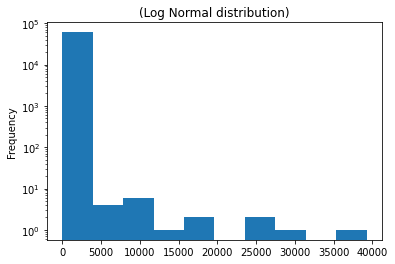

In [ ]:
# Visualize the gene expression distribution of the first sample
gene_exp_data.iloc[:, 0].plot(
    kind='hist', logy=True, title='(Log Normal distribution)'
)
plt.show()

Genes are (highly, moderately, or lowly) expressed in cells, expression values (FPKM/TPM) ranges are: 

* expression level is below cutoff (0.5 FPKM or 0.5 TPM), extremely low values might be the result of technical or biological noise rather than active genes.
* expression level is low (between 0.5 to 10 FPKM or 0.5 to 10 TPM).
* expression level is medium (between 11 to 1000 FPKM or 11 to 1000 TPM).
* expression level is high (more than 1000 FPKM or more than 1000 TPM).

Since cancer is caused by certain changes to genes that regulate cell growth and division, gene expression values will differ between normal cells and tumor cells.




In [ ]:
# Demonstrate the difference in gene expression between normal and tumor cell

# Genes expression of Primary solid tumor (pst) (sample-ID endswith 01)
pst = gene_exp_data.iloc[:, 1]
# Genes expression of Solid tissue normal (stn) (sample-ID endswith 11)
stn = gene_exp_data.iloc[:, 10]

# Bucketing gene expression in both stn and pst samples
exp_range_stn = pd.cut(stn, bins=[0, 0.5, 10, 1000, stn.max()])
exp_range_pst = pd.cut(pst, bins=[0, 0.5, 10, 1000, pst.max()])

print(f'Frequency of gene expression in normal sample ({stn.name})')
print(exp_range_stn.value_counts(), '\n')

print(f'Frequency of gene expression in tumor sample ({pst.name})')
print(exp_range_pst.value_counts(), '\n')


Frequency of gene expression in normal sample (TCGA-49-4512-11)
(0.0, 0.5]             12825
(0.5, 10.0]            11521
(10.0, 1000.0]          3732
(1000.0, 11798.689]       43
Name: TCGA-49-4512-11, dtype: int64 

Frequency of gene expression in tumor sample (TCGA-86-7953-01)
(0.0, 0.5]            17616
(0.5, 10.0]           11465
(10.0, 1000.0]         4863
(1000.0, 4046.383]       20
Name: TCGA-86-7953-01, dtype: int64 



In [ ]:
# Find the gene that has maximum value in normal sample 
highly_exp_gene_normal = stn[stn == stn.max()].index[0]
# Find the expression value of (highly_exp_gene_normal) in tumor sample
tumor_exp = pst[highly_exp_gene_normal]
change_perc = (stn.max() - tumor_exp) / stn.max() * 100

print(f"Expression of {highly_exp_gene_normal} in normal cell: {stn.max()}")
print(f"Expression of {highly_exp_gene_normal} in tumor cell: {tumor_exp}")
print(f"Expression is decreased by {round(change_perc, 3)}% in tumor")

Expression of ENSG00000168484 in normal cell: 11798.6894439
Expression of ENSG00000168484 in tumor cell: 10.0354139593
Expression is decreased by 99.915% in tumor


**Interpretation of the above result:**

The expression of ENSG00000168484 (or SFTPC) gene is decreased significantly in tumor sample, the gene encodes [surfactant protein-B (SP-B)](https://en.wikipedia.org/wiki/Surfactant_protein_B) that is responsible for making breathing process easy by lowering surface tension. [Studies](https://www.tandfonline.com/doi/full/10.1080/21691401.2019.1648283) show that there is a link between under-expression of SFTPC gene and LUAD progression. 

# Data Preprocessing
Before passing data into a machine learning model, it should be first preprocessed and transformed into a well-readable format to be easily parsed by the model.









### **Preprocessing steps that will be applied to the data are:**
####1. Keeping reviewed genes and filtering out unreviewed ones
To understand the difference between reviewed and unreviewed genes, firstly ***genome annotation*** process should be explained.

Human genome annotation started in response to human genome project (HGP), which  was carried out in 1990 with a goal of determining the DNA sequence of the entire human genome, since knowing only the order of DNA bases is of little use, unless the structural and functional information of genes can be identified. Genome annotation is a process of identifying gene locations and all of the coding regions in a genome and determining what those genes do. [link](https://en.wikipedia.org/wiki/DNA_annotation)

There are two approaches that are co-exist and complement each other for human genome annotation (manual & automated). In manual annotation, genes information are extracted from literature and public databases, and reviewed by human, while automated annotation attempt to perform complex pattern-matching of protein to DNA via computer analysis, and genes are await for human review (I.e. unreviewed).

Reviewed genes are much more reliable than unreviewed, since automatic annotation is brone to error and can result in misannotated genes. 
Filtering out unreviewed genes is done through [Uniprot](https://www.uniprot.org/) (database relevant to genome annotation) by uploading list of genes to [Retrieve/ID mapping](https://www.uniprot.org/uploadlists/) tool and downloading only the reviewed ones.

Refer to the image and code cells below for filtering steps
<div>
<img src="https://drive.google.com/uc?export=view&id=1Qn66GGb_SbVj9Phs1O9Ir2tvn5kWdb3H" width="700"/>
</div>

In [ ]:
# Save gene names (Ensembl) in txt file (rows separated by new lines)
# This is the file uploaded to Retrieve/ID mapping tool
genes = gene_exp_data.index.tolist()
genes_file = '/content/drive/MyDrive/Phi/LUAD/genes.txt'
with open(genes_file, 'w') as genes_file:
  genes_file.write('\n'.join(str(gene) for gene in genes))

In [ ]:
# Read reviewed genes downloaded from uniprot website
path = '/content/drive/MyDrive/Phi/LUAD/uniprot_reviewed.tab.gz'
reviewed = pd.read_csv(path, sep='\t', compression='gzip', index_col=0)


def split_genes(genes_col):
  """Split the genes that are in one row."""
  genes_list = []
  for row in genes_col.tolist():
    if ',' in row:
      row_list = row.split(',')
      genes_list.extend(row_list)
    else:
      genes_list.append(row)
  return genes_list

# In reviewed genes file, some rows contains more than one Ensembl gene
reviewed_genes = split_genes(reviewed.index)
# Filtering gene_exp_data to have only data of reviewed genes: (filter 1)
reviewed_data = gene_exp_data[gene_exp_data.index.isin(reviewed_genes)]

####2. Filtering out low expressed genes
Filtering out genes with expression less than 10 FPKM in more than 75% of samples, in other words, keeping active genes with expression >= 10 FPKM in at least 25% of samples.

In [ ]:
# Filtering out low expressed genes: (filter 2)
gene_exp_condition = reviewed_data >= 10
threshold = reviewed_data.shape[1] * 0.25
active_data = reviewed_data[gene_exp_condition.sum(axis=1) >= threshold]

####3. Filtering out normal samples
The last two digits in TCGA sample barcode represent [sample type](https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes) (Tumor, Normal, control).






In [ ]:
# Sample types
list(set(map(lambda sample: sample[-2:], active_data.columns)))

['01', '11', '02']

Sample types found in data are:

*   '01' : Primary Solid Tumor
*   '11' : Solid Tissue Normal
*   '02' : Recurrent Solid Tumor





In [ ]:
# Keep only tumor samples (filter 3)
tumor_data = active_data.filter(regex='01$', axis=1)

####4. Replicates Summarization

In [ ]:
'Number of replicates in samples', (tumor_data.shape[1] - tumor_data.columns.unique().shape[0])

('Number of replicates in samples', 20)

In [ ]:
# Summarize sample replicates with median 
summarized_data = tumor_data.groupby(level=0, axis=1).agg(np.median)

In [ ]:
# Data shape in each step of filtering
print('original data shape ', gene_exp_data.shape)
print('reviewed genes data shape ', reviewed_data.shape)
print('reviewed and active genes data shape ', active_data.shape)
print('data with only tumor samples ', tumor_data.shape)
print('tumor data without samples replicates ', summarized_data.shape)

original data shape  (60483, 594)
reviewed genes data shape  (19319, 594)
reviewed and active genes data shape  (5424, 594)
data with only tumor samples  (5424, 533)
tumor data without samples replicates  (5424, 513)


####5. Log2 Transformation
Data distribution is [highly skewed](https://colab.research.google.com/drive/1he2hk88kvHujOBIkSpT4XeuB-0355-sz#scrollTo=a3KhncITwqTS&line=5&uniqifier=1), using log2 transformation will decrease the skewness and make data conform more closely to the normal distribution, which in turn improves the fit of the clustering model.

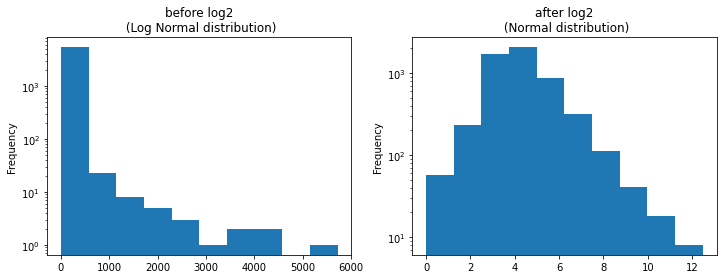

In [ ]:
# Log2 Transformation of filtered_data 
log_data = np.log2(summarized_data + 1)

# Visualize the distribution changes before and after Log2 Transformation
fig, axis = plt.subplots(1,2, figsize=(12,4))
summarized_data.iloc[:, 0].plot(
    kind='hist', logy=True, title='before log2\n (Log Normal distribution)',
    ax=axis[0]
)

log_data.iloc[:, 0].plot(
    kind='hist', logy=True, title='after log2\n (Normal distribution)',
    ax=axis[1]
)

####6. Z-Score Transformation
In this step, data will be standardized on the same scale to have mean of zero and standard deviation equal to one, this ensures that the different features are comparable and that the clustering model will generate good quality clusters, without being dominated by an odd feature (has a range of values much larger than the others).

Z-score will be applied to:

1.   each sample across genes: used to cluster samples, clusters will be further passed down to survival analysis.
2.   each gene across samples: used to cluster genes, clusters will be further passed down to Gene Ontology (GO) term enrichment analysis, and DNA-motif analysis.





In [ ]:
# Z-score transformation 
from scipy.stats import zscore

# Z-score transformation (for each gene)
z_genes = zscore(log_data, axis=1)

# Z-score transformation (for each sample)
transposed_data = log_data.T
z_samples = zscore(transposed_data, axis=1)


# Clustering
Clustering is an [unsupervised](https://www.guru99.com/unsupervised-machine-learning.html#:~:text=Unsupervised%20Learning%20is%20a%20machine,deals%20with%20the%20unlabelled%20data.) machine learning approach, that involves automatically discovering natural grouping in data. In our analysis clustering model gathers: 
1. **Samples** in clusters according to the pattern in expression values across genes, so samples within a cluster share similar characteristics, and with the use of clinical data it could tell us more about the prognosis of pateints, how they response to different treatments or thier expected life span (Survival Analysis).
2. **Genes** in clusters according to the pattern in expression values across samples, here genes within a cluster are proportionally expressed (co-expressed), further analyses (Gene Ontology (GO) term enrichment analysis, and DNA-motif analysis) were used to identify those biological processes, cellular locations and molecular functions that are impacted in LUAD.


We used simple clustering algorithm **k-means clustering**, that uses an iterative technique to group unlabeled data into pre-defined number of clusters (K) based on cluster centers (centroids), in which the average distance of data points to their respective centroid is minimized. [link](https://www.codecademy.com/learn/machine-learning/modules/dspath-clustering/cheatsheet)

To use k-means algorithm, number of clusters (K) should be determined by using one or set of evaluation metrics (Inertia, Dunn index, Silhouette, Davies–Bouldin index, Calinski-Harabasz index), these metrics have their own method in [sklearn](https://scikit-learn.org/stable/modules/classes.html#:~:text=See%20the%20Clustering%20performance,of%20the%20model%20itself.).

In [ ]:
!pip install validclust    # optimization of k (validate clustering results)
!pip install lifelines     # for survival analysis

In [ ]:
!pip install kneed

For n_clusters = 2 The average silhouette_score is : 0.07227354538600066
For n_clusters = 3 The average silhouette_score is : 0.06619209719076206
For n_clusters = 4 The average silhouette_score is : 0.06406346201229632
For n_clusters = 5 The average silhouette_score is : 0.06472976053094931
For n_clusters = 6 The average silhouette_score is : 0.05706533056801534


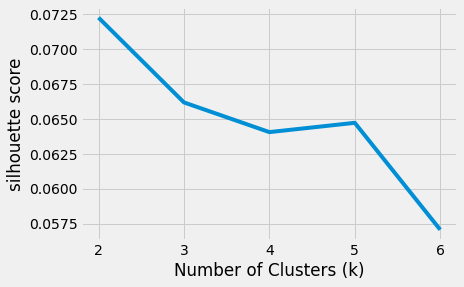

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.style as style

range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_n_clusters = []

for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=11)
    cluster_labels = clusterer.fit_predict(z_genes)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(z_genes, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)

    

style.use("fivethirtyeight")
plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(z_samples, method='ward'))
# plt.axhline(y=6, color='r', linestyle='--')

In [ ]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(z_genes, method='ward'))
# plt.axhline(y=6, color='r', linestyle='--')

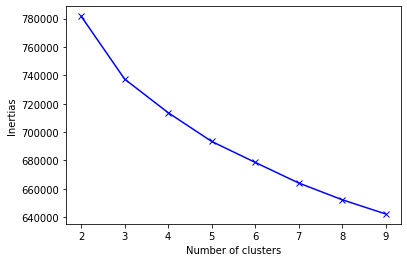

In [ ]:
#from validclust.validclust import ValidClust
from sklearn.cluster import KMeans
#from kneed import KneeLocator
import warnings
warnings.filterwarnings('ignore')  # Ignore warning msg

inertias = []
for k in range(2,10):
  kmeans = KMeans(n_clusters=k, random_state=11)
  kmeans.fit(z_samples)
  inertias.append(kmeans.inertia_)

plt.plot(range(2, 10), inertias, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertias') 
plt.show()
# 1.Clustering of samples
# Choose optimal number of K
# samples_vclust = ValidClust(k=range(2,10))
# samples_vclust.fit_predict(z_samples)
# samples_vclust.plot()

In the heatmap, darker cells are associated with higher-quality clusterings, and from the plot we can see that most of method/index pairs seems to be pointing to 2 as being an optimal value for k.

Beside number of clusters (K), **random_state** should be defined when using k-means, since initial centroids are randomly selected, they will be different in each run making it difficult to reproduce clustering results, here **random_state** comes in to Determine random number generation for centroid initialization.

In [ ]:
# KMeans clustering of samples
samples_model = KMeans(n_clusters=2, random_state=11)
samples_model.fit(z_samples)
samples_labels = samples_model.labels_

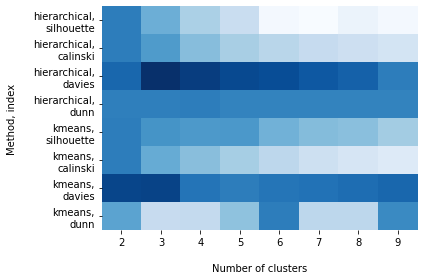

In [ ]:
# 2.Clustering of genes
# Choose optimal number of K
genes_vclust = ValidClust(k=range(2,10))
genes_vclust.fit_predict(z_genes)
genes_vclust.plot()

In [ ]:
# KMeans clustering of genes
genes_model = KMeans(n_clusters=4, random_state=11)
genes_model.fit(z_genes)
genes_labels = genes_model.labels_

In [ ]:
# Extract case_submitter_id (patient_id) from sample_id
case_submitter_id = list(map(
    lambda idx: re.sub(r'-01$', '', idx), log_data.columns)
)

# Create dataframe for sample clusters
sample_cluster_df = pd.DataFrame({'case_submitter_id':case_submitter_id,
                                  'cluster':samples_labels})
sample_cluster_df = pd.get_dummies(sample_cluster_df, columns=['cluster'])
print(sample_cluster_df.head())

  case_submitter_id  cluster_0  cluster_1
0      TCGA-05-4244          0          1
1      TCGA-05-4249          0          1
2      TCGA-05-4250          1          0
3      TCGA-05-4382          1          0
4      TCGA-05-4384          0          1


In [ ]:
# Bulid a survival analysis dataframe

# Load clinical file
clinical_path = '/content/drive/MyDrive/Phi/LUAD/clinical/clinical.tsv'
clinical_data = pd.read_csv(clinical_path, sep='\t', na_values="'--")

# Drop duplicates, subsetting the desired columns
clinical_data.drop_duplicates(subset='case_submitter_id', inplace=True)
cols = ['case_submitter_id', 'days_to_death',
        'days_to_last_follow_up','vital_status']
clinical_data = clinical_data[cols]

# Drop null records in both cols[1:3]
clinical_data.dropna(subset=cols[1:3], thresh=1, inplace=True)

# Create time_to_event col in years 
days_to_event = []
for index, row in clinical_data.iterrows():
  if row.vital_status == 'Alive':
    days_to_event.append(row.days_to_last_follow_up)
  else:
    days_to_event.append(row.days_to_death)

clinical_data['time_to_event'] = list(
    map(lambda days: days/365, days_to_event)
)

# Artificial censoring at 5 years
condition = clinical_data.time_to_event > 5
clinical_data.loc[condition, 'time_to_event'] = 5
clinical_data.loc[condition, 'vital_status'] = 'Alive'

# Create a boolean col from vital_status 
clinical_data['event_observed'] = clinical_data['vital_status'].map(
                                  {'Dead':True, 'Alive':False})
# Drop unwanted columns
clinical_data.drop(cols[1:], inplace=True, axis=1)

# Merge clinical_data with sample_cluster_df (survival analysis df)
survival_df = sample_cluster_df.merge(clinical_data,
                                      on='case_submitter_id',
                                      how='inner')
survival_df.set_index('case_submitter_id', inplace=True)

In [ ]:
#*** delete
patient_cluster_0 = survival_df[survival_df.cluster_0 == 1]
patient_cluster_1 = survival_df[survival_df.cluster_1 == 1]
path_0 = '/content/drive/MyDrive/Phi/LUAD/clusters/patient_cluster_0.tsv'
file_0 = patient_cluster_0.to_csv(path_0, sep='\t')
path_1 = '/content/drive/MyDrive/Phi/LUAD/clusters/patient_cluster_1.tsv'
file_1 = patient_cluster_1.to_csv(path_1, sep='\t')

In [ ]:
survival_df.head(3)

,cluster_0,cluster_1,time_to_event,event_observed
case_submitter_id,,,,
TCGA-05-4244,0,1,0.000000,False
TCGA-05-4249,0,1,4.172603,False
TCGA-05-4250,1,0,0.331507,True


<lifelines.CoxPHFitter: fitted with 504 total observations, 332 right-censored observations>
             duration col = 'time_to_event'
                event col = 'event_observed'
      baseline estimation = breslow
   number of observations = 504
number of events observed = 172
   partial log-likelihood = -939.55
         time fit was run = 2021-03-12 18:22:56 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
cluster_0   0.37       1.45       0.15             0.07             0.67                 1.07                 1.96

             z    p   -log2(p)
covariate                     
cluster_0 2.42 0.02       5.99
---
Concordance = 0.57
Partial AIC = 1881.09
log-likelihood ratio test = 5.88 on 1 df
-log2(p) of ll-ratio test = 6.03

<lifelines.CoxPHFitter: fitted with 504 total observations, 332 right-censored observations>
             duration col = 'time_to_event'
                event col = 'event_observed'
      baseline estimation = breslow
   number of observations = 504
number of events observed = 172
   partial log-likelihood = -939.55
         time fit was run = 2021-03-12 18:22:56 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
cluster_1  -0.37       0.69       0.15            -0.67            -0.07                 0.51                 0.93

              z    p   -log2(p)
covariate                      
cluster_1 -2.42 0.02       5.99
---
Concordance = 0.57
Partial AIC = 1881.09
log-likelihood ratio test = 5.88 on 1 df
-log2(p) of ll-ratio test = 6.03

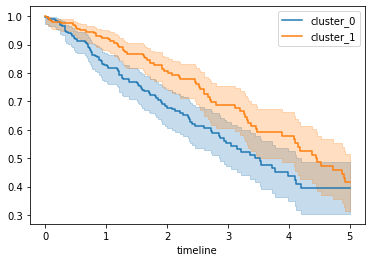

In [ ]:
# Survival analysis
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

# Dividing survival_df into groups for survival models
cluster_0_kmf = survival_df.query('cluster_0 == 1')
cluster_1_kmf = survival_df.query('cluster_1 == 1')

cluster_0_cox = survival_df.loc[:, survival_df.columns != 'cluster_1']
cluster_1_cox = survival_df.loc[:, survival_df.columns != 'cluster_0']

t = 'time_to_event'
e = 'event_observed'


def survival_analysis(label, kmf_df, cox_df):
  # 1.Kaplan meier model
  kmf = KaplanMeierFitter(label=label)
  kmf.fit(kmf_df[t], kmf_df[e])
  kmf.plot()
  # Save the plot for later evaluation 
  plt.savefig('/content/drive/MyDrive/Phi/LUAD/kmf_plot.png')
  
  # 2.Cox Proportional Hazard model
  cph = CoxPHFitter()
  cph.fit(cox_df, t, e)
  cph.print_summary()


# Cluster_label_0
survival_analysis('cluster_0', cluster_0_kmf, cluster_0_cox)
# Cluster_label_1
survival_analysis('cluster_1', cluster_1_kmf, cluster_1_cox)

In [ ]:
# Create file for all genes (background) to retrieve GO terms 
background_genes = pd.DataFrame(log_data.index)
background_path = '/content/drive/MyDrive/Phi/LUAD/GO_term/background.tsv'
background_file = background_genes.to_csv(background_path, header=False,
                                          index=False, sep='\t')

In [ ]:
# Add cluster_label column to background_genes df
background = background_genes.copy()
background['cluster_label'] = genes_labels
background.set_index(0, inplace=True)

background.head(3)

,cluster_label
0,
ENSG00000146083,2
ENSG00000198242,0
ENSG00000134108,3


In [ ]:
#*** delete
gene_cluster_0 = background[background.cluster_label == 0]
gene_cluster_1 = background[background.cluster_label == 1]
gene_cluster_2 = background[background.cluster_label == 2]
gene_cluster_3 = background[background.cluster_label == 3]
gene_clusters = [gene_cluster_0, gene_cluster_1,
                 gene_cluster_2, gene_cluster_3]

for label, df in enumerate(gene_clusters):
  path = '/content/drive/MyDrive/Phi/LUAD/clusters/gene_cluster_' + str(label) + '.tsv'
  file = df.to_csv(path, sep='\t')

In [ ]:
# Load GO terms dataframe
background_go_path = '/content/drive/MyDrive/Phi/LUAD/GO_term/bkg_GO.tab'
background_go = pd.read_csv(background_go_path, sep='\t')

# Rename the label of genes column
genes_column = background_go.columns[-1]
background_go.rename(columns={genes_column: 'genes'}, inplace=True)

# Drop unwanted columns
background_go.drop(['Entry', 'Status'], axis=1, inplace=True)

print('Background "before GO term mapping" shape', background.shape)
print('Background "after GO term mapping" shape', background_go.shape)

Background "before GO term mapping" shape (5424, 1)
Background "after GO term mapping" shape (5434, 4)


In [ ]:
# Display background_go df that has genes duplicates
duplicates_bool = background_go.genes.duplicated(keep=False)

# Genes that are duplicated
# Will be used later to check the results of processing duplicates 
duplicated_genes = background_go[duplicates_bool].genes.unique()

background_go[duplicates_bool]

,Gene ontology (biological process),Gene ontology (cellular component),Gene ontology (molecular function),genes
179,"positive regulation of gene expression, epigen...",cytosol [GO:0005829]; nucleoplasm [GO:0005654],NaN,ENSG00000186184
180,"transcription, DNA-templated [GO:0006351]",RNA polymerase I complex [GO:0005736]; RNA pol...,DNA binding [GO:0003677]; DNA-directed 5'-3' R...,ENSG00000186184
1630,protein targeting to membrane [GO:0006612],cytoplasm [GO:0005737]; nascent polypeptide-as...,DNA binding [GO:0003677]; unfolded protein bin...,ENSG00000196531
1631,cardiac ventricle development [GO:0003231]; he...,cytoplasm [GO:0005737]; extracellular exosome ...,DNA binding [GO:0003677]; transcription coacti...,ENSG00000196531
1985,female pregnancy [GO:0007565]; negative regula...,cytoplasm [GO:0005737]; extracellular region [...,NaN,ENSG00000087460
1986,activation of adenylate cyclase activity [GO:0...,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,adenylate cyclase activator activity [GO:00108...,ENSG00000087460
1987,adenylate cyclase-activating G protein-coupled...,cytosol [GO:0005829]; membrane [GO:0016020]; p...,G-protein beta/gamma-subunit complex binding [...,ENSG00000087460
1988,adenylate cyclase-activating dopamine receptor...,apical plasma membrane [GO:0016324]; cytosol [...,adenylate cyclase activator activity [GO:00108...,ENSG00000087460
2082,Golgi vesicle transport [GO:0048193]; multicel...,cytosol [GO:0005829]; Golgi apparatus [GO:0005...,"DNA-binding transcription factor activity, RNA...",ENSG00000257923
2083,intra-Golgi vesicle-mediated transport [GO:000...,Golgi apparatus [GO:0005794]; Golgi membrane [...,NaN,ENSG00000257923


* 9 genes are duplicated.
* Some terms will be repeated in the same records (After merging duplicates) ---> this problem will be fixed later on.

In [ ]:
# Function for processing duplicates
def merge_rows(rows):
  # Drop NaN rows
  rows_without_nan = rows.dropna()

  # Return NaN if all rows are NaNs
  if len(rows_without_nan) == 0:
    return np.nan

  merged_rows = '; '.join(rows_without_nan)
  return merged_rows


# Merge duplicates
cols_to_merge = background_go.columns[:-1]
background_go = background_go.groupby('genes')[cols_to_merge].agg(merge_rows)

print('background_go (After duplicates merging) shape', background_go.shape)

background_go (After duplicates merging) shape (5423, 3)


In [ ]:
# Check if merging duplicates works as expected (First check)
background_go[background_go.index.isin(duplicated_genes)]

,Gene ontology (biological process),Gene ontology (cellular component),Gene ontology (molecular function)
genes,,,
ENSG00000087460,female pregnancy [GO:0007565]; negative regula...,cytoplasm [GO:0005737]; extracellular region [...,adenylate cyclase activator activity [GO:00108...
ENSG00000100300,adrenal gland development [GO:0030325]; aging ...,mitochondrial outer membrane [GO:0005741]; end...,androgen binding [GO:0005497]; benzodiazepine ...
ENSG00000109113,antigen processing and presentation [GO:001988...,nucleolus [GO:0005730]; cilium [GO:0005929]; e...,GTPase activity [GO:0003924]; GTP binding [GO:...
ENSG00000120802,"regulation of transcription, DNA-templated [GO...",chromatin [GO:0000785]; nuclear envelope [GO:0...,cadherin binding [GO:0045296]; DNA binding [GO...
ENSG00000149806,antibacterial humoral response [GO:0019731]; a...,cytosol [GO:0005829]; cytosolic small ribosoma...,RNA binding [GO:0003723]; RNA binding [GO:0003...
ENSG00000176087,positive regulation of translation in response...,integral component of membrane [GO:0016021]; G...,pyrimidine nucleotide-sugar transmembrane tran...
ENSG00000186184,"positive regulation of gene expression, epigen...",cytosol [GO:0005829]; nucleoplasm [GO:0005654]...,DNA binding [GO:0003677]; DNA-directed 5'-3' R...
ENSG00000196531,protein targeting to membrane [GO:0006612]; ca...,cytoplasm [GO:0005737]; nascent polypeptide-as...,DNA binding [GO:0003677]; unfolded protein bin...
ENSG00000257923,Golgi vesicle transport [GO:0048193]; multicel...,cytosol [GO:0005829]; Golgi apparatus [GO:0005...,"DNA-binding transcription factor activity, RNA..."


In [ ]:
pd.set_option('display.max_colwidth', None)

# Check if merging duplicates works as expected (Second check)
background_go.loc[background_go.index == 'ENSG00000149806', 'Gene ontology (molecular function)']

genes
ENSG00000149806    RNA binding [GO:0003723]; RNA binding [GO:0003723]; structural constituent of ribosome [GO:0003735]
Name: Gene ontology (molecular function), dtype: object

In [ ]:
pd.set_option('display.max_colwidth', 50)

# Adding cluster_label column to background_go
background_go = background_go.merge(
    background, how='left', right_index=True, left_index=True,
)
# Create df for each gene cluster by filtering background_go
cluster_0_go = background_go[background_go['cluster_label'] == 0]
cluster_1_go = background_go[background_go['cluster_label'] == 1]
cluster_2_go = background_go[background_go['cluster_label'] == 2]
cluster_3_go = background_go[background_go['cluster_label'] == 3]

In [ ]:
cluster_3_go.head(3)

,Gene ontology (biological process),Gene ontology (cellular component),Gene ontology (molecular function),cluster_label
genes,,,,
ENSG00000000971,complement activation [GO:0006956]; complement...,blood microparticle [GO:0072562]; extracellula...,heparan sulfate proteoglycan binding [GO:00433...,3.0
ENSG00000002549,proteolysis [GO:0006508],cytosol [GO:0005829]; extracellular exosome [G...,aminopeptidase activity [GO:0004177]; manganes...,3.0
ENSG00000002586,homotypic cell-cell adhesion [GO:0034109]; pos...,cytoplasm [GO:0005737]; focal adhesion [GO:000...,NaN,3.0


In [ ]:
# Building enrichment dataframes 

def go_term_count(go_df, domain, counts_label):
  go_domain_series = go_df.loc[:, domain]
  go_domain_df = go_df.loc[:, [domain]]

  # Split terms in each records 
  go_domain_df = go_domain_df.assign(
      splitted_terms=go_domain_series.str.split(';')
  )
  # Get rid of repeated terms in same record
  for idx, terms in go_domain_df['splitted_terms'].iteritems():
    if type(terms) == list:
      go_domain_df['splitted_terms'][idx] = list(set(terms))

  # Unpack list in each record
  go_domain_df = go_domain_df.explode('splitted_terms')
  # Strip whitespaces
  go_domain_df['splitted_terms'] = go_domain_df['splitted_terms'].str.strip()

  # Term occurence counts in (background | gene_cluster)
  term_count = go_domain_df['splitted_terms'].value_counts()
  # Convert the counts to dataframe
  go_term_df = term_count.rename_axis(domain).to_frame(counts_label)

  return go_term_df


# Domains
bio = 'Gene ontology (biological process)'
cell = 'Gene ontology (cellular component)'
mol = 'Gene ontology (molecular function)'

# Terms counts of each domain
# 1. In background
bio_background = go_term_count(background_go, bio, 'background')
cell_background = go_term_count(background_go, cell, 'background')
mol_background = go_term_count(background_go, mol, 'background')

# 2.In gene clusters
bio_clusters = []
cell_clusters = []
mol_clusters = []
clusters_dfs = {'cluster_0': cluster_0_go, 'cluster_1': cluster_1_go,
                'cluster_2': cluster_2_go, 'cluster_3': cluster_3_go}

for cluster_label, cluster_df in clusters_dfs.items():
  bio_clusters.append(go_term_count(cluster_df, bio, cluster_label))
  cell_clusters.append(go_term_count(cluster_df, cell, cluster_label))
  mol_clusters.append(go_term_count(cluster_df, mol, cluster_label))
  

In [ ]:
bio_background.head(3)

,background
Gene ontology (biological process),
positive regulation of transcription by RNA polymerase II [GO:0045944],367
signal transduction [GO:0007165],296
neutrophil degranulation [GO:0043312],295


In [ ]:
def merge_dfs(df1, df2):
  merged_df = df1.merge(
      df2, how='right', right_index=True, left_index=True)
  return merged_df


# Gene clusters enrichment dataframes
bio_enrich_clusters = []
cell_enrich_clusters = []
mol_enrich_clusters = []

for cluster_df in bio_clusters:
  bio_enrich_clusters.append(merge_dfs(bio_background, cluster_df))

for cluster_df in cell_clusters:
  cell_enrich_clusters.append(merge_dfs(cell_background, cluster_df))

for cluster_df in mol_clusters:
  mol_enrich_clusters.append(merge_dfs(mol_background, cluster_df))

In [ ]:
mol_enrich_clusters[2].head(3)

,background,cluster_2
Gene ontology (molecular function),,
identical protein binding [GO:0042802],662,164
metal ion binding [GO:0046872],512,155
RNA binding [GO:0003723],820,150


In [ ]:
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests


# Defining the sizes (number of genes) in clusters & background
clusters = [cluster_0_go, cluster_1_go, cluster_2_go, cluster_3_go]
clusters_size = [cluster.shape[0] for cluster in clusters]
cluster_label_size = dict(enumerate(clusters_size))
background_size = background_go.shape[0]


# Calculate P_value
def p_value(background_count, cluster_count,
                           cluster_label: int):
  
  cluster_size = cluster_label_size[cluster_label]
  # Define fisher_exact matrix scalars
  cluster_term = cluster_count
  not_cluster_but_term = background_count
  cluster_but_not_term = cluster_size - cluster_count
  not_cluster_not_term = background_size - (cluster_term + 
                                          background_count + 
                                          cluster_but_not_term)
  # Fisher_exact matrix
  array = np.array([[cluster_term, not_cluster_but_term],
                    [cluster_but_not_term, not_cluster_not_term]])
  # Calculate p_value using fisher_exact
  odds_ratio, p_value = fisher_exact(array)
  
  return p_value



# Create list of lists for each cluster, each list has df for each domain
clusters_number = 4
all_domains_clusters_list = []

for cluster_label in range(clusters_number):
  domain_list = [bio_enrich_clusters[cluster_label],
                 cell_enrich_clusters[cluster_label],
                 mol_enrich_clusters[cluster_label]]

  all_domains_clusters_list.append(domain_list)

# Adding (p_value & corrected_p_value) columns to each df
for cluster_label, domains_dfs in enumerate(all_domains_clusters_list):
  for enrich_df in domains_dfs:
    cluster_col = 'cluster_' + str(cluster_label)
    enrich_df['p_value'] = enrich_df.apply(
    lambda df: p_value(df.background, df[cluster_col], cluster_label), axis=1
)
    enrich_df['corrected_p_value'] = multipletests(enrich_df['p_value'],
                                                   method='fdr_bh')[1]


In [ ]:
# Rename columns to include the size of (clusters & background)
domains_list = [bio_enrich_clusters, cell_enrich_clusters,
                mol_enrich_clusters]

for domain in domains_list:
  for cluster_label in range(clusters_number):
    cluster_old_name = 'cluster_' + str(cluster_label)
    cluster_new_name = f'{cluster_old_name} ({clusters_size[cluster_label]})'
    background_new_name = f'background ({background_size})'

    domain[cluster_label].rename(
        columns={'background': background_new_name,
                 cluster_old_name: cluster_new_name} , inplace=True
    )

In [ ]:
# Terms with significant corrected_p_value (from more siginficant to less)
significant = mol_enrich_clusters[2].corrected_p_value <= 0.05
mol_enrich_clusters[2][significant].sort_values(by='corrected_p_value')

,background (5423),cluster_2 (1398),p_value,corrected_p_value
Gene ontology (molecular function),,,,
RNA binding [GO:0003723],820,150,3.373030e-17,4.277002e-14
structural constituent of ribosome [GO:0003735],139,3,9.735095e-15,6.172050e-12
identical protein binding [GO:0042802],662,164,1.834973e-05,7.755819e-03


In [ ]:
# For later evaluation

# Save significant records of the enrichment dfs in a csv file
for domain_label, domain in enumerate(domains_list):
  domains_abbrev = ['bio', 'cell', 'mol']

  for cluster_label in range(clusters_number):
    # Filter only significant records in ascending order
    significant = domain[cluster_label].corrected_p_value <= 0.05
    significant_df = domain[cluster_label][significant]
    significant_df.sort_values(by='corrected_p_value', inplace=True)

    # Save significant_df
    significant_path = ('/content/drive/MyDrive/Phi/LUAD/GO_term/' + 
                        str(domains_abbrev[domain_label]) + '_cluster_' +
                        str(cluster_label) + '.tsv')
    significant_file = significant_df.to_csv(significant_path, sep='\t')


In [ ]:
# DNA motif analysis to find the regulators (TFs) of co-expressed genes

# Load genomic features file 
genomic_features_path = ('/content/drive/MyDrive/Phi/LUAD/genomic_data' +
                         '/genomic_features.gff.gz')
genomic_features = pd.read_csv(genomic_features_path, compression='gzip',
                               sep='\t', skiprows=9, header=None)

In [ ]:
pd.set_option('display.max_colwidth', None)
# Display column 8 with records corresponded to genes only
genomic_features[genomic_features.iloc[:, 2] == 'gene'].iloc[:,8]

19                    ID=gene-MIR6859-1;Dbxref=GeneID:102466751,HGNC:HGNC:50039,miRBase:MI0022705;Name=MIR6859-1;description=microRNA 6859-1;gbkey=Gene;gene=MIR6859-1;gene_biotype=miRNA;gene_synonym=hsa-mir-6859-1
26                                                                                       ID=gene-MIR1302-2HG;Dbxref=GeneID:107985730,HGNC:HGNC:52482;Name=MIR1302-2HG;gbkey=Gene;gene=MIR1302-2HG;gene_biotype=lncRNA
31         ID=gene-MIR1302-2;Dbxref=GeneID:100302278,HGNC:HGNC:35294,miRBase:MI0006363;Name=MIR1302-2;description=microRNA 1302-2;gbkey=Gene;gene=MIR1302-2;gene_biotype=miRNA;gene_synonym=hsa-mir-1302-2,MIRN1302-2
36                   ID=gene-FAM138A;Dbxref=GeneID:645520,HGNC:HGNC:32334;Name=FAM138A;description=family with sequence similarity 138 member A;gbkey=Gene;gene=FAM138A;gene_biotype=lncRNA;gene_synonym=F379,FAM138F
43                                        ID=gene-OR4F5;Dbxref=GeneID:79501,HGNC:HGNC:14825;Name=OR4F5;description=olfactory receptor family 4 s

In [ ]:
pd.set_option('display.max_colwidth', 50)
# Preprocessed the genomic_features df

# (1) Select only genes records
genes_records = genomic_features.iloc[:, 2] == 'gene'
genomic_features = genomic_features[genes_records]

# Create a GeneID column from the last column
genomic_features[9] = genomic_features.iloc[:, 8].str.extract(
    r'(ID=gene-)(.*)(;Dbxref=GeneID)', expand=True
)[1]

# Select desired columns
genomic_features = genomic_features.iloc[:, [0,2,3,4,6,9]]

# Renaming the columns
genomic_features.rename(columns={0:'Chromosome', 2:'Gene',
                                 3:'Start', 4:'End', 6:'Strand',
                                 9:'Gene_Name'}, inplace=True)

In [ ]:
genomic_features.head(3)

,Chromosome,Gene,Start,End,Strand,Gene_Name
19,NC_000001.11,gene,17369.0,17436.0,-,MIR6859-1
26,NC_000001.11,gene,29926.0,31295.0,+,MIR1302-2HG
31,NC_000001.11,gene,30366.0,30503.0,+,MIR1302-2


In [ ]:
# Retrieve Gene Names of the background genes (Uniprot) 
mapped_genes_path = '/content/drive/MyDrive/Phi/LUAD/GO_term/gene_names.tab'
mapped_genes = pd.read_csv(mapped_genes_path, sep='\t')

# Drop all columns except ensemble genes and their gene names
cols_to_drop = mapped_genes.columns[1:-1]
mapped_genes.drop(columns=cols_to_drop, inplace=True)
mapped_genes.shape

(5417, 2)

Uniprot is continuously updated, so the size of gene ids is 5417 instead of 5423 as got in GO term analysis.

In [ ]:
# Renaming the columns
col_names = mapped_genes.columns
mapped_genes.rename(columns={col_names[0]:'Ensembl',
                             col_names[1]:'Gene_Name'}, inplace=True)

mapped_genes.head(3)

,Ensembl,Gene_Name
0,ENSG00000146083,RNF44
1,ENSG00000198242,RPL23A
2,ENSG00000134108,ARL8B


In [ ]:
# Check for NaNs
print(mapped_genes.isna().sum(), '\n')

# Check if there are more than one gene in same record
mapped_genes[mapped_genes.Ensembl.str.contains(',')]

Ensembl      0
Gene_Name    0
dtype: int64 



,Ensembl,Gene_Name
5141,"ENSG00000132475,ENSG00000163041",H3-3A; H3-3B


In [ ]:
# Check if there are multiple names in same record (Gene_Name)
mapped_genes[mapped_genes.Gene_Name.str.contains(';')]

,Ensembl,Gene_Name
152,ENSG00000163682,RPL9; RPL9P7; RPL9P8; RPL9P9
1775,ENSG00000276180,H4C1; H4C2; H4C3; H4C4; H4C5; H4C6; H4C8; H4C9...
2456,ENSG00000180596,H2BC4; H2BC6; H2BC7; H2BC8; H2BC10
3863,ENSG00000188536,HBA1; HBA2
5141,"ENSG00000132475,ENSG00000163041",H3-3A; H3-3B


Some ensemble genes has multiple gene names each one has different location in the genome.
All of these gene names will be considered in retrieving DNA-motif. 

In [ ]:
# Check for duplicates
mapped_genes[mapped_genes.Gene_Name.duplicated(keep=False)]

,Ensembl,Gene_Name
178,ENSG00000186184,POLR1D
179,ENSG00000186184,POLR1D
1623,ENSG00000196531,NACA
1624,ENSG00000196531,NACA
1977,ENSG00000087460,GNAS
1978,ENSG00000087460,GNAS
1979,ENSG00000087460,GNAS
1980,ENSG00000087460,GNAS
2074,ENSG00000257923,CUX1
2075,ENSG00000257923,CUX1


In [ ]:
# Preprocessing mapped_genes df
# 1. Drop duplicates
mapped_genes.drop_duplicates(inplace=True)

# 2. Deal with the row of multiple genes
rows_to_append = pd.DataFrame([['ENSG00000163041', 'H3-3A'],
                               ['ENSG00000132475', 'H3-3B']],
                              columns=['Ensembl','Gene_Name'])

mapped_genes = mapped_genes.append(rows_to_append, ignore_index=True)
mapped_genes = mapped_genes[~ mapped_genes.Ensembl.str.contains(',')]

# 3. Deal with rows of multiple Gene_Name
mapped_genes['Gene_Name'] = mapped_genes.Gene_Name.str.split(';')
mapped_genes = mapped_genes.explode('Gene_Name')
mapped_genes['Gene_Name'] = mapped_genes['Gene_Name'].str.strip()

In [ ]:
# Make a copy of mapped_genes df
# Add suffix to identify duplicated Ensembl
mapped_genes_with_suffix = mapped_genes.copy()
mapped_genes_with_suffix['Ensembl'] += (
    mapped_genes_with_suffix.groupby('Ensembl').cumcount().astype('str').radd('_')
)

In [ ]:
# Check if suffixing went well
mapped_genes_with_suffix[mapped_genes_with_suffix.Ensembl.str.contains('_3')]

,Ensembl,Gene_Name
152,ENSG00000163682_3,RPL9P9
1773,ENSG00000276180_3,H4C4
2450,ENSG00000180596_3,H2BC8


In [ ]:
# Merge mapped_genes_with_suffix with genomic_features (with suffix)
# This df will be used to create fasta file for the background genes
genes_features_with_suffix = genomic_features.merge(
    mapped_genes_with_suffix, on='Gene_Name', how='right'
)
genes_features_with_suffix.shape

(5428, 7)

In [ ]:
# Merge mapped_genes with genomic_features (without suffix)
# This df will be used to create fasta file for clusters genes
genes_features = genomic_features.merge(
    mapped_genes, on='Gene_Name', how='right'
)
genes_features.shape

(5428, 7)

In [ ]:
# Check for NaNs
genes_features.isna().sum()

Chromosome    27
Gene          27
Start         27
End           27
Strand        27
Gene_Name      0
Ensembl        0
dtype: int64

In [ ]:
def preprocessing(df):
  # Drop NaNs rows
  df.dropna(inplace=True)
  # Drop unwanted columns
  df.drop(columns=['Gene', 'Gene_Name'], inplace=True)
  
  # Change dtype of Start and End columns to int
  df = df.astype({'Start':int, 'End':int})
  # Correct the indexing (after deleting NaNs rows with their index)
  df.reset_index(inplace=True)

  return df


# Preprocess merged dfs
genes_features = preprocessing(genes_features)
genes_features_with_suffix = preprocessing(genes_features_with_suffix)

In [ ]:
genes_features.head(3)

,index,Chromosome,Start,End,Strand,Ensembl
0,0,NC_000005.10,176526704,176544206,-,ENSG00000146083
1,1,NC_000017.11,28719985,28724359,+,ENSG00000198242
2,2,NC_000003.12,5122292,5180911,+,ENSG00000134108


In [ ]:
genes_features_with_suffix.head(3)

,index,Chromosome,Start,End,Strand,Ensembl
0,0,NC_000005.10,176526704,176544206,-,ENSG00000146083_0
1,1,NC_000017.11,28719985,28724359,+,ENSG00000198242_0
2,2,NC_000003.12,5122292,5180911,+,ENSG00000134108_0


In [ ]:
# Save mapped_genes_features df
genes_features_with_suffix_path = ('/content/drive/MyDrive/Phi/LUAD' + 
                                   '/genomic_data/mapped_genes_features.bed')
genes_features_with_suffix_file = genes_features_with_suffix.to_csv(
    genes_features_with_suffix_path, sep='\t', header=None, index=False
)

* original (starting) gene number = 5424 (size of all clusters)
* 5424 gene name mapping (uniprot) = 5417
* 5417 without duplicates = 5406
* 5406 after preprocessing = 5428 --> 5407 unique
* 5428 after merging with gff file and have location = 5401 (27 NaNs) --> 5383 unique

gene loss from the size of all clusters = 5424 - 5383 = 41 genes

In [ ]:
!pip install pysam

In [ ]:
# Load whole genome fasta file
!curl -o whole_genome.fna.gz https://ftp.ncbi.nih.gov/genomes/refseq/vertebrate_mammalian/Homo_sapiens/latest_assembly_versions/GCF_000001405.39_GRCh38.p13/GCF_000001405.39_GRCh38.p13_genomic.fna.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  920M  100  920M    0     0  15.7M      0  0:00:58  0:00:58 --:--:-- 16.6M


In [ ]:
# Unzip whole_genome file
!gunzip /content/whole_genome.fna.gz

In [ ]:
from pysam import FastaFile
whole_genome_path = '/content/whole_genome.fna'
whole_genome = FastaFile(whole_genome_path)


# Extract the (1000 bp) upstream strand of each gene
def upstream_strand(chr, start, end, strand):
  if strand == '+':
    upstream_start = (start - 1) - 1000 
    # -1 : python index start from 0, while genome index start from 1
    upstream_end = start - 1
  else:
    upstream_start = end # (end - 1) + 1 = end || +1: to not include gene bp
    upstream_end = upstream_start + 1000
  
  # Get the 1000 bp upstream strand
  upstream = whole_genome.fetch(chr, upstream_start, upstream_end)

  # Nitrogenous bases with their complements
  bases = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
  if strand == '-':
    # Read the upstream strand in reverse
    upstream = upstream[::-1]
    # Get the complement of upstream strand
    upstream_list = list(map(lambda base: bases[base], upstream.upper()))
    upstream = ''.join(upstream_list)
    return upstream

  else:
    return upstream.upper()


In [ ]:
upstream_background_path = ('/content/drive/MyDrive/Phi/LUAD/' +
                            'genomic_data/upstream_bkg.fna')

# Write fasta file for the upstream strands (background genes)
with open(upstream_background_path, 'w') as upstream_background:
  for gene_idx in range(genes_features_with_suffix.shape[0]):

    seq_name = genes_features_with_suffix.Ensembl[gene_idx]
    # Parameters of upstream_strand function
    chromosome = genes_features_with_suffix.Chromosome[gene_idx]
    start = genes_features_with_suffix.Start[gene_idx]
    end = genes_features_with_suffix.End[gene_idx]
    strand = genes_features_with_suffix.Strand[gene_idx]
    
    seq_list = upstream_strand(chromosome, start, end, strand)
    # Write the upstream results in the file
    upstream_background.write('>' + seq_name + '\n' + seq_list + '\n')


In [ ]:
# Merge background df (contains cluster_label col) with..
# mapped_genes_features df
clusters_genes_features = genes_features.merge(
    background, left_on='Ensembl', right_index=True, how='left'
)
clusters_genes_features.head(3)

,index,Chromosome,Start,End,Strand,Ensembl,cluster_label
0,0,NC_000005.10,176526704,176544206,-,ENSG00000146083,2
1,1,NC_000017.11,28719985,28724359,+,ENSG00000198242,0
2,2,NC_000003.12,5122292,5180911,+,ENSG00000134108,3


In [ ]:
# Add suffix to clusters_genes_features df
clusters_genes_features['Ensembl'] += (
    clusters_genes_features.groupby('Ensembl').cumcount().astype('str').radd('_')
)

In [ ]:
# Check if suffixing went well
clusters_genes_features[clusters_genes_features.Ensembl.str.contains('_3')]

,index,Chromosome,Start,End,Strand,Ensembl,cluster_label
1767,1779,NC_000006.12,26188710,26189112,-,ENSG00000276180_3,0
2453,2469,NC_000006.12,26216200,26216688,-,ENSG00000180596_3,1


In [ ]:
# Filtering the ensembls of each cluster
label_col = clusters_genes_features.cluster_label
clusters = [clusters_genes_features[label_col == label]
            for label in range(clusters_number)]
# Note: (clusters_number) variable defined earlier

upstream_background = FastaFile(upstream_background_path)

# Create fasta file for each cluster
for cluster_label, cluster in enumerate(clusters):
  upstream_cluster_path = ('/content/drive/MyDrive/Phi/LUAD/' +
                           'genomic_data/upstream_cluster_' + 
                           str(cluster_label) + '.fna')
  # Correct the indexing
  cluster.reset_index(inplace=True)

  with open(upstream_cluster_path, 'w') as upstream_cluster:
    for gene_idx in range(cluster.shape[0]):
      seq_name = cluster.Ensembl[gene_idx]
      seq_list = upstream_background.fetch(seq_name)
      upstream_cluster.write('>' + seq_name + '\n' + seq_list + '\n')
                           

(transcription_factor_result) folder has 4 folders each one correspond to gene cluster.
Each cluster folder has multiple tsv files for each motif (motifs are gotten from STREME tool).
Each file has transcription factors for one motif (TFs are gotten from Tomtom tool).

In [ ]:
# Concat Transcription factor results dfs for each cluster
tf_result_folder = ('/content/drive/MyDrive/Phi/LUAD/genomic_data/' +
                    'transcription_factor_result')
clusters_tfs = []
iter_count = 1
for subdir, dir, files in os.walk(tf_result_folder):
  cluster_dfs = []
  for file in files:
    file_path = os.path.join(subdir,file)
    tf_df = pd.read_csv(file_path, sep='\t', skipfooter=3, engine='python')
    cluster_dfs.append(tf_df)
  if iter_count != 1: # In first iteration, nested for loop not running (cluster_dfs = [])
    single_df_for_cluster = pd.concat(cluster_dfs, ignore_index=True)
    clusters_tfs.append(single_df_for_cluster)

  iter_count += 1

In [ ]:
# Display TFs for gene cluster_0
clusters_tfs[0].head()

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
0,1-AGTAGAGACRG,ZFP28_HUMAN.H11MO.0.C,7,0.004812,1.92964,1.0,11,AGTAGAGACAG,TGACACAAGAAGAAATAGAA,-
1,1-AGTAGAGACRG,ZN708_HUMAN.H11MO.0.C,8,0.006483,2.59968,1.0,11,AGTAGAGACAG,GCCTAATAAGCAGGTACAGC,+
2,2-CGCGGTGGC,AP2B_HUMAN.H11MO.0.B,1,0.014203,5.69540,1.0,9,CGCGGTGGC,GCCCGGGGGC,+
3,2-CGCGGTGGC,RFX1_HUMAN.H11MO.0.B,2,0.016047,6.43493,1.0,9,CGCGGTGGC,GCCCCGGTTGCCATGGCGACGG,+
4,2-CGCGGTGGC,SNAI1_HUMAN.H11MO.0.C,0,0.017823,7.14718,1.0,8,CGCGGTGGC,CCAGGTGG,+


In [ ]:
# For later evaluation 

# Save tf results for each cluster
shared_path = ('/content/drive/MyDrive/Phi/LUAD/genomic_data' +
               '/TFs_results_for_evaluation/tf_cluster_')
for cluster_label, cluster in enumerate(clusters_tfs):
  cluster_tfs_path = shared_path + str(cluster_label) + '.tsv'
  cluster_tfs_file = cluster.to_csv(cluster_tfs_path, sep='\t')

In [ ]:
%%shell
jupyter nbconvert --to html /content/LUAD.ipynb